# Getting parameters from runs with py3DCORE_h4c

In [67]:
%load_ext autoreload

%autoreload 2

import heliosat as heliosat
import logging as logging
import datetime as datetime
import numpy as np
import os as os
import pickle as pickle
import py3dcore_h4c as py3dcore_h4c
import matplotlib.pyplot as plt
import pandas as pds
import seaborn as sns

from py3dcore_h4c.fitter.base import custom_observer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
from heliosat.util import sanitize_dt

logging.basicConfig(level=logging.INFO)
logging.getLogger("heliosat.spice").setLevel("WARNING")
logging.getLogger("heliosat.spacecraft").setLevel("WARNING")

For plotting, we need the following information about the times.

In [69]:
t_launch = datetime.datetime(2022, 9, 5, 18, 45, tzinfo=datetime.timezone.utc) # launch time assumed at CME impact at PSP at 14.72 Rs

t_s = datetime.datetime(2022, 9, 7, 8, tzinfo=datetime.timezone.utc) 
t_e = datetime.datetime(2022, 9, 8, 5, tzinfo=datetime.timezone.utc)

t_fit = [
        datetime.datetime(2022, 9, 7, 9, tzinfo=datetime.timezone.utc),
        datetime.datetime(2022, 9, 7, 15, tzinfo=datetime.timezone.utc),
        datetime.datetime(2022, 9, 7, 21, tzinfo=datetime.timezone.utc),
        datetime.datetime(2022, 9, 8, 3, tzinfo=datetime.timezone.utc)#,
       # datetime.datetime(2022, 9, 7, 18, tzinfo=datetime.timezone.utc)
]

In [70]:
# specify directory from which to read pickle file (= results of runs)
path = 'solo06092022_heeq_512_4FP_allP_2/'

# Get the list of all files in path
dir_list = sorted(os.listdir(path))

resfile = []
respath = []
# we only want the pickle-files
for file in dir_list:
    if file.endswith(".pickle"):
        resfile.append(file) 
        respath.append(os.path.join(path,file))
        print(os.path.join(path, file))       

solo06092022_heeq_512_4FP_allP_2/00.pickle
solo06092022_heeq_512_4FP_allP_2/01.pickle
solo06092022_heeq_512_4FP_allP_2/02.pickle
solo06092022_heeq_512_4FP_allP_2/03.pickle
solo06092022_heeq_512_4FP_allP_2/04.pickle
solo06092022_heeq_512_4FP_allP_2/05.pickle
solo06092022_heeq_512_4FP_allP_2/06.pickle
solo06092022_heeq_512_4FP_allP_2/07.pickle
solo06092022_heeq_512_4FP_allP_2/08.pickle
solo06092022_heeq_512_4FP_allP_2/09.pickle
solo06092022_heeq_512_4FP_allP_2/10.pickle


INFO:py3dcore_h4c.fitter.base:Using HelioSat to retrieve observer data


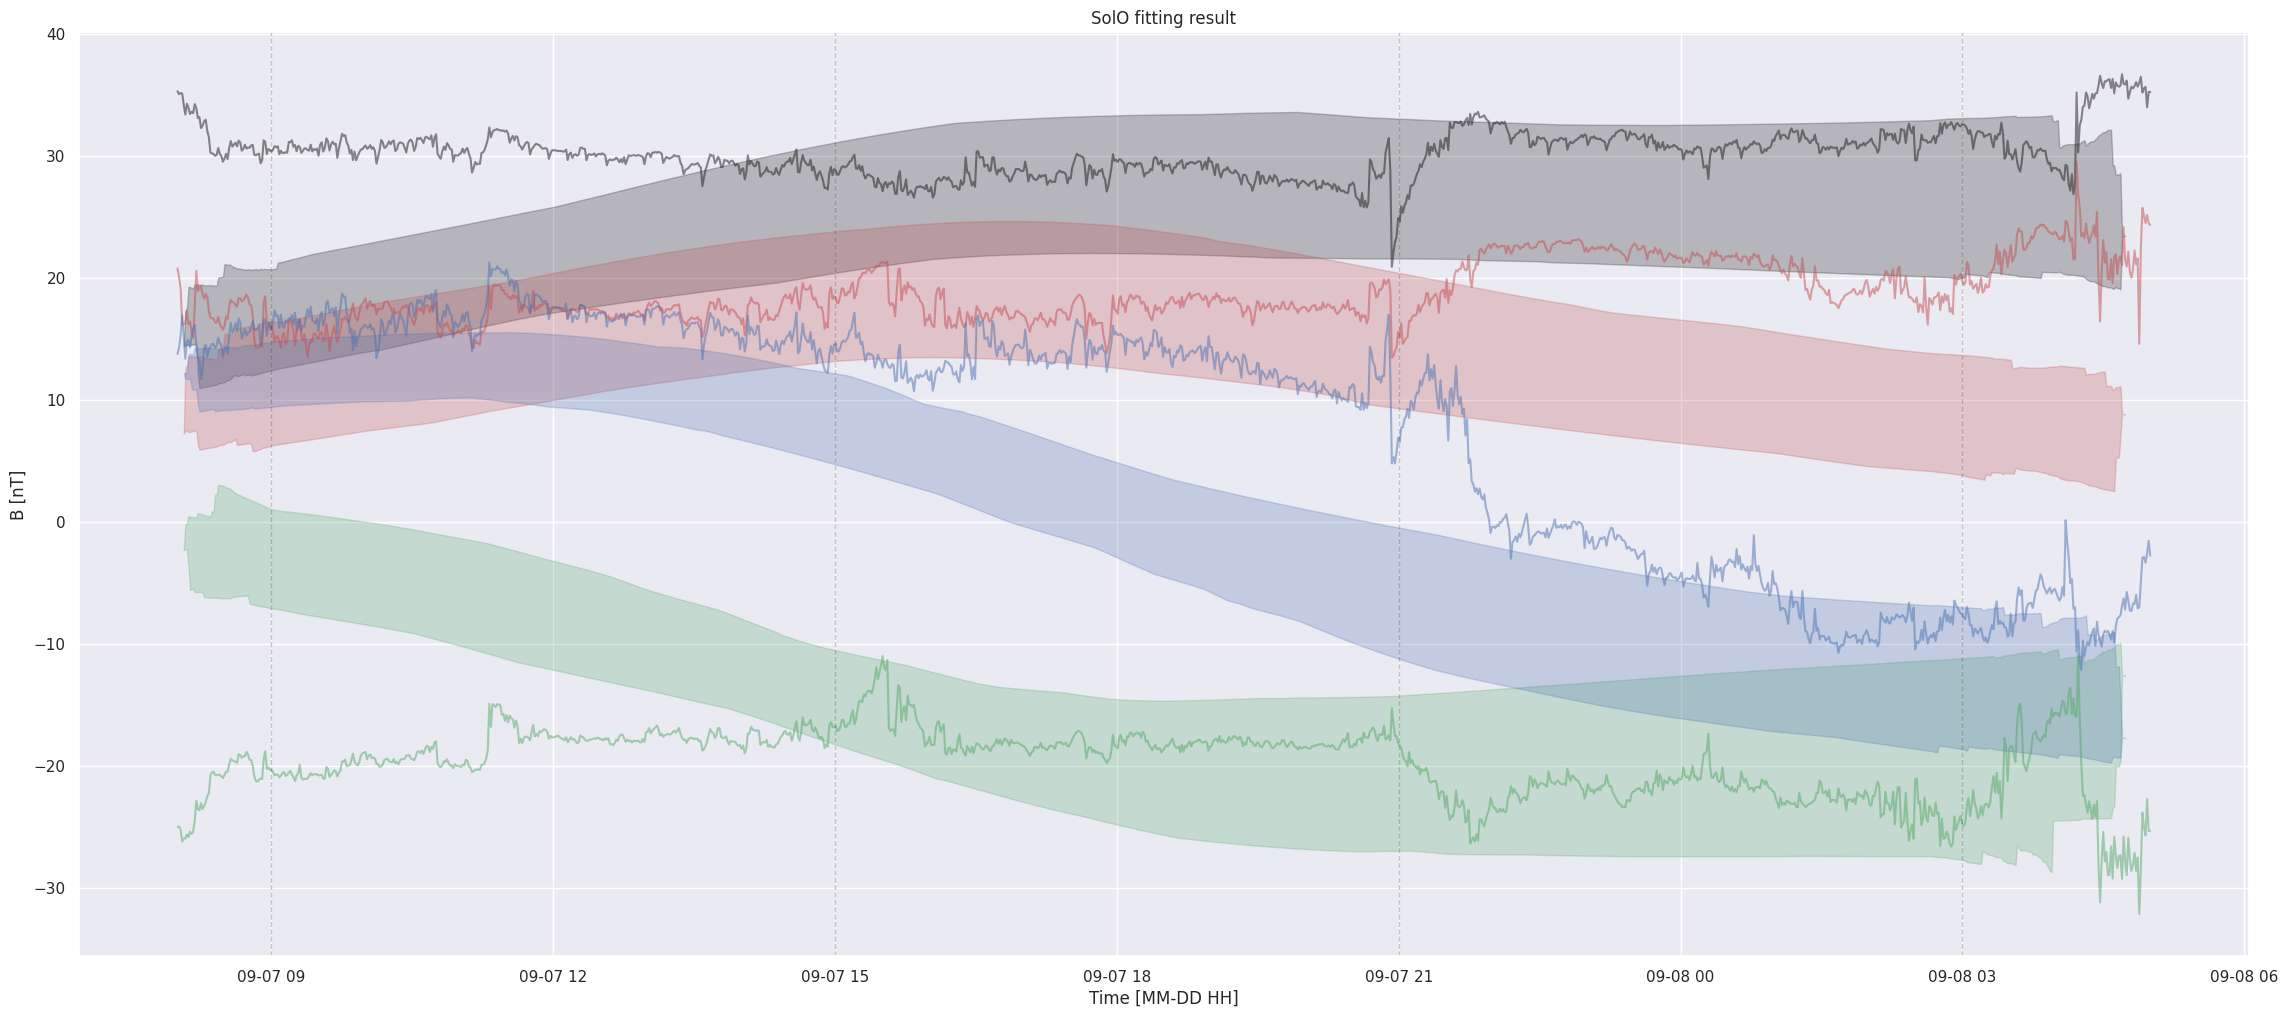

In [71]:
# plot the results 

#t_s_psp = datetime.datetime(2022, 6, 2, 10, tzinfo=datetime.timezone.utc)
#t_e_psp = datetime.datetime(2022, 6, 3, 2, tzinfo=datetime.timezone.utc)

obs_obj = custom_observer('solo_2022sep.p')

# get measurements from PSP via heliosat
tt, bb = obs_obj.get([t_s, t_e], "mag", reference_frame="HEEQ", as_endpoints=True, return_datetimes=True, smoothing="gaussian")

# get ensemble_data
ed = py3dcore_h4c.generate_ensemble(respath[-1], tt, reference_frame="HEEQ", reference_frame_to="HEEQ", max_index=128)

plt.figure(figsize=(28, 12))
plt.title("SolO fitting result")
plt.plot(tt, np.sqrt(np.sum(bb**2, axis=1)), "k", alpha=0.5)
plt.plot(tt, bb[:, 0], "r", alpha=0.5)
plt.plot(tt, bb[:, 1], "g", alpha=0.5)
plt.plot(tt, bb[:, 2], "b", alpha=0.5)
plt.fill_between(tt, ed[0][3][0], ed[0][3][1], alpha=0.25, color="k")
plt.fill_between(tt, ed[0][2][0][:, 0], ed[0][2][1][:, 0], alpha=0.25, color="r")
plt.fill_between(tt, ed[0][2][0][:, 1], ed[0][2][1][:, 1], alpha=0.25, color="g")
plt.fill_between(tt, ed[0][2][0][:, 2], ed[0][2][1][:, 2], alpha=0.25, color="b")
plt.ylabel("B [nT]")
plt.xlabel("Time [MM-DD HH]")
for _ in t_fit:
    plt.axvline(x=_, lw=1, alpha=0.25, color="k", ls="--")
plt.savefig(path+'%s.png' %resfile[-1])    
plt.show()

In [72]:
# read from pickle file
file = open(respath[-1], "rb")
data = pickle.load(file)
file.close()

# get overview of whats in pickle file
cnt = 0
for item in data:
    print(item)
    cnt += 1
    
# get index ip for run with minimum eps    
epses_t = data["epses"]
ip = np.argmin(epses_t)    

# get parameters (stored in iparams_arr) for the run with minimum eps
model_objt = data["model_obj"]
iparams_arrt = model_objt.iparams_arr
iparams_arrt[ip]

locked
dt_0
model_kwargs
observers
model
iter_i
hist_eps
hist_time
hist_eps_dim
model_obj
data_obj
epses


array([ 0.0000000e+00, -1.7785112e+02, -1.8610742e+00,  1.8277586e+01,
        3.3219230e-01,  1.0609351e+00,  1.8370640e+01,  1.6532706e+03,
        1.0722438e+02,  1.1400000e+00,  1.6400000e+00,  4.7676651e+01,
        2.4835633e-01,  3.3144620e+02], dtype=float32)

## Use scatter plot to plot range of all runs

In [73]:
df = pds.DataFrame(iparams_arrt)
cols = df.columns.values.tolist()

# drop first column, and others in which you are not interested
df.drop(df.columns[[0, 9, 10]], axis=1, inplace=True)

# rename columns
df.columns = ['lon', 'lat', 'inc', 'D1AU', 'delta', 'launch radius', 'init speed', 't factor', 'B1AU', 'gamma', 'vsw']
print(df.head())

          lon        lat        inc      D1AU     delta  launch radius  \
0  179.000626   8.240526  36.277260  0.341999  1.090041      15.793431   
1  171.454453 -15.596228   5.206204  0.347512  1.433277      18.892179   
2 -169.395599  -5.806373  12.241405  0.347519  1.311822      15.450966   
3  175.959518  -7.732522  15.153632  0.341204  1.448436      13.324337   
4 -174.873596   6.323988  29.941296  0.344437  1.264641      19.501558   

    init speed    t factor       B1AU     gamma         vsw  
0  1553.336914   98.663536  47.487427  0.253487  375.396332  
1  1646.352783   76.963097  44.929306  0.236206  241.617783  
2  1560.059448   56.004223  21.154051  0.202191  422.548950  
3  1180.739868  101.680618  39.641006  0.230929  386.808014  
4  1554.656982   93.108681  45.033051  0.301676  465.721039  


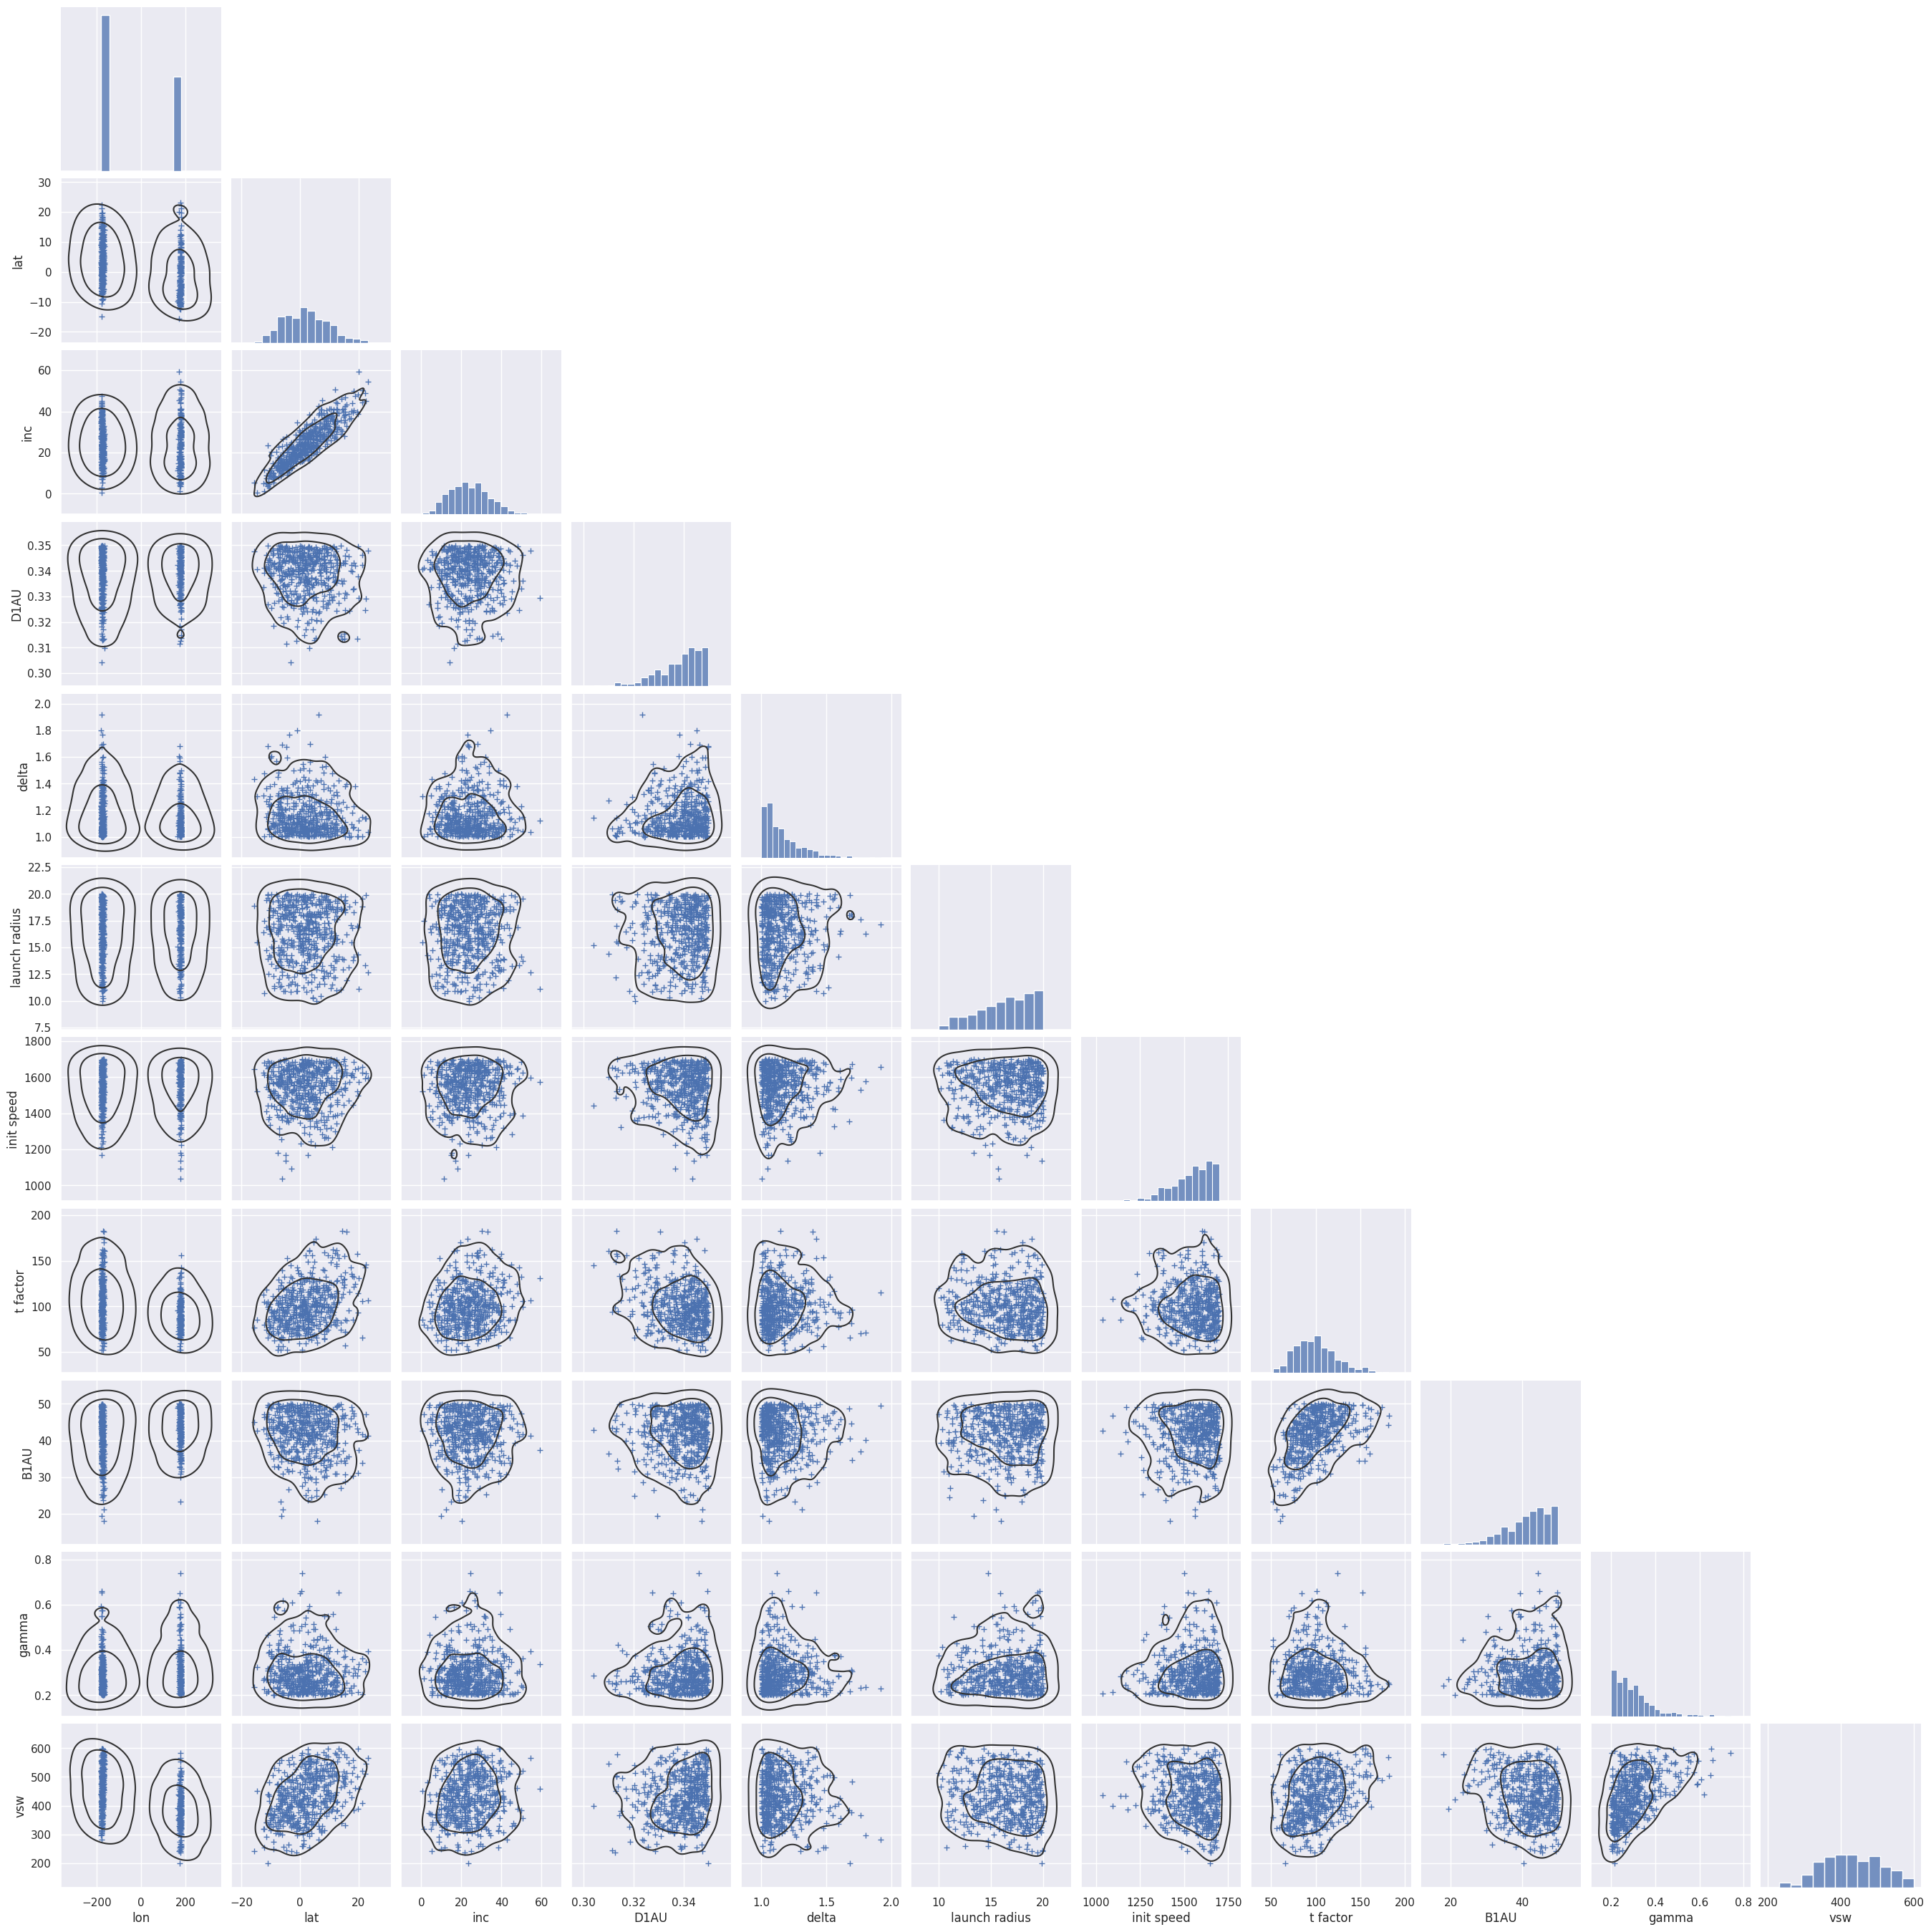

In [74]:
sns.set_style('white')
sns.set()

g = sns.pairplot(df, 
                 corner=True,
                 plot_kws=dict(marker="+", linewidth=1)
                )
g.map_lower(sns.kdeplot, levels=[0.05, 0.32], color=".2") #  levels are 2-sigma and 1-sigma contours
g.savefig(path+'scatter_plot_matrix.png')
plt.show()